# Single Obeject Localization
https://towardsdatascience.com/object-localization-using-pre-trained-cnn-models-such-as-mobilenet-resnet-xception-f8a5f6a0228d

In [16]:
import csv
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input as mobile_preproc
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as res_preproc
from tensorflow.keras.applications.xception import Xception, preprocess_input as xcept_preproc
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import typing
# import the necessary packages
from collections import namedtuple
import numpy as np
import cv2
from PIL import Image, ImageOps
# importing XML parsing library for parsing the data
import xml.etree.ElementTree as ET

In [3]:
#BoundingBox
Bounding_Box = namedtuple('Bounding_Box', ['xmin', 'ymin', 'xmax', 'ymax'])
# The following function will read the xml and return the values for xmin, ymin, xmax, ymax for formulating the bounding box
def building_bounding_box(path_to_xml_annotation):
    tree = ET.parse(path_to_xml_annotation)
    root = tree.getroot()
    path_to_box = './object/bndbox/'
    xmin = int(root.find(path_to_box + "xmin").text)
    ymin = int(root.find(path_to_box + "ymin").text)
    xmax = int(root.find(path_to_box + "xmax").text)
    ymax = int(root.find(path_to_box + "ymax").text)
    return Bounding_Box(xmin, ymin, xmax, ymax)

In [4]:
def resize_image_with_bounds(path_to_image: str, bounding_box=None, target_size=None):
    image = Image.open(path_to_image)
    width, height = image.size
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    #the following code helps determining where to pad or is it not necessary for the images we have.
    # If the difference between the width and height was odd((height<width)case), we add one pixel on one side
    # If the difference between the height and width was odd((height>width)case), then we add one pixel on one side.
    #if both of these are not the case, then pads=0, no padding is needed, since the image is already a square itself.
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2
    # When we pad the image to square, we need to adjust all the bounding box values by the amounts we added on the left or top.
    #The "bonus" pads are always done on the bottom and right so we can ignore them in terms of the box.
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    if bounding_box is not None:
        new_xmin = bounding_box.xmin + w_pad
        new_xmax = bounding_box.xmax + w_pad
        new_ymin = bounding_box.ymin + h_pad
        new_ymax = bounding_box.ymax + h_pad
    # We need to also apply the scalr to the bounding box which we used in resizing the image
    if target_size is not None:
        # So, width and height have changed due to the padding resize.
        width, height = image.size
        image = image.resize(target_size)
        width_scale = target_size[0] / width
        height_scale = target_size[1] / height
    if bounding_box is not None:
        new_xmin = new_xmin * width_scale
        new_xmax = new_xmax * width_scale
        new_ymin = new_ymin * height_scale
        new_ymax = new_ymax * height_scale
        image_data = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    # The image data is a 3D array such that 3 channels ,RGB of target_size.(RGB values are 0-255)
    if bounding_box is None:
        return image_data, None
    return (image_data, Bounding_Box(new_xmin, new_ymin, new_xmax, new_ymax))

In [5]:
def plot_with_box(image_data: np.ndarray, bounding_box: Bounding_Box, compare_box: Bounding_Box = None, ax: plt.Axes = None, title: str = ""):
    if ax is None:
        fig,ax = plt.subplots(1)
    ax.imshow(image_data)
    ax.set_title(title)
    # Creating a Rectangle patch for the changed one
    boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
    bounding_box.xmax - bounding_box.xmin,
    bounding_box.ymax - bounding_box.ymin,
    linewidth=3, edgecolor='y', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(boxA)
    #Creating another Rectangular patch for the real one
    if compare_box is not None:
        boxB = patches.Rectangle((compare_box.xmin, compare_box.ymin),
        compare_box.xmax - compare_box.xmin,
        compare_box.ymax - compare_box.ymin,
        linewidth=2, edgecolor='b', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(boxB)
        #FOR FINDING INTERSECTION OVER UNION
        xA = max(bounding_box.xmin, compare_box.xmin)
        yA = max(bounding_box.ymin, compare_box.ymin)
        xB = min(bounding_box.xmax, compare_box.xmax)
        yB = max(bounding_box.ymax, compare_box.ymax)
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        boxAArea = (bounding_box.xmax - bounding_box.xmin + 1) * (bounding_box.ymax - bounding_box.ymin + 1)
        boxBArea = (compare_box.xmax - compare_box.xmin + 1) * (compare_box.ymax - compare_box.ymin + 1)
        iou =interArea/float(boxAArea+boxBArea-interArea)
        #By intersection of union I mean intersection over union(IOU) #itself
        print('intersection of union =',iou)
    if ax is None:
        plt.show()

In [6]:
def setting_sample_from_name(data_images: str, data_xmlAnnotations: str, sample_name: str, target_size):
    path_to_image = os.path.join(data_images, sample_name + '.jpg')
    path_to_xml = os.path.join(data_xmlAnnotations, sample_name + '.xml')
    original_bounding_box = building_bounding_box(path_to_xml)
    image_data, bounding_box = resize_image_with_bounds(path_to_image, original_bounding_box, target_size)
    return (image_data, bounding_box)

In [22]:
Processed_Data = namedtuple("Processed_Data", ["image", "species", "box"])
Splitted_Dataset = namedtuple('Splitted_Dataset', ['x', 'y_class', 'y_box', 'index'])
Full_Dataset = namedtuple('Full_Dataset', ['train', 'validation', 'test'])

def split_dataset(data_pros: typing.List[Processed_Data], preproc_func: typing.Callable, validation_split: float = 0.2, test_split: float = 0.2):
    validation_split += test_split

    x_train = []
    y_class_train = []
    y_box_train = []
    idc_train = []

    x_validation = []
    y_class_validation = []
    y_box_validation = []
    idc_validation = []

    x_test = []
    y_class_test = []
    y_box_test = []
    idc_test = []

    for i, (image, species, bounding_box) in enumerate(data_pros):
        rand_val = np.random.random()
        if rand_val > validation_split:
            x_train.append(preproc_func(image))
            y_class_train.append(species)
            y_box_train.append(bounding_box)
            idc_train.append(i)
        elif rand_val > test_split:
            x_validation.append(preproc_func(image))
            y_class_validation.append(species)
            y_box_validation.append(bounding_box)
            idc_validation.append(i)
        else:
            x_test.append(preproc_func(image))
            y_class_test.append(species)
            y_box_test.append(bounding_box)
            idc_test.append(i)
            
    x_train = np.array(x_train)
    y_class_train = np.array(y_class_train)
    y_box_train = np.array(y_box_train)
    idc_train = np.array(idc_train)

    x_validation = np.array(x_validation)
    y_class_validation = np.array(y_class_validation)
    y_box_validation = np.array(y_box_validation)
    idc_validation = np.array(idc_validation)
    
    x_test = np.array(x_test)
    y_class_test = np.array(y_class_test)
    y_box_test = np.array(y_box_test)
    idc_test = np.array(idc_test)
    
    train_dataset = Splitted_Dataset(x_train, y_class_train, y_box_train, idc_train)
    validation_dataset = Splitted_Dataset(x_validation, y_class_validation, y_box_validation, idc_validation)
    test_dataset = Splitted_Dataset(x_test, y_class_test, y_box_test, idc_test)
    
    return Full_Dataset(train_dataset, validation_dataset, test_dataset)

In [7]:
def train(model, dataset, epochs):
    model.compile(optimizer='adam', metrics=['accuracy'],loss=['binary_crossentropy', 'mse'],loss_weights=[800, 1]  )
    #lets run it through 10 epochs
    history = model.fit(
        dataset.train.x, 
        [dataset.train.y_class, dataset.train.y_box], 
        validation_data=( dataset.validation.x, 
                        [ dataset.validation.y_class, dataset.validation.y_box]),
        epochs=epochs,
        verbose=True)
    return history

In [31]:
def eval(rand_num: int, splitted_dataset: Splitted_Dataset, model: Model, processed_data: typing.List[Processed_Data], suptitle=""):
    ncols = 3
    nrows = (rand_num // ncols) + 1 if rand_num % ncols else rand_num // ncols
    fig, axes = plt.subplots(nrows, ncols)
    axes = axes.reshape(ncols * nrows)
    for i in range(rand_num):
        data = processed_data[splitted_dataset.index[i]]
        img, species, true_bounding_box = data.image, data.species, data.box
        pred = model.predict(np.array([img]))
        if pred[0][0] < .5:
            title = f"{pred[0][0].item():.4f} it is a Cat"
        else:
            title = f"{pred[0][0].item():.4f} it is a dog"
        plot_with_box(img, Bounding_Box(*pred[1][0]), Bounding_Box(*true_bounding_box), ax=axes[i], title=title)
    fig.suptitle(suptitle), fig.tight_layout(), fig.show()

## Dataset

### Data Source

In [10]:
data_images = 'sample-data/AI_dataset_pets/images'
data_ClassList = 'sample-data/AI_dataset_pets/annotations/list.txt'
data_xmlAnnotations = 'sample-data/AI_dataset_pets/annotations/xmls'
TARGET_SIZE = (224, 224)

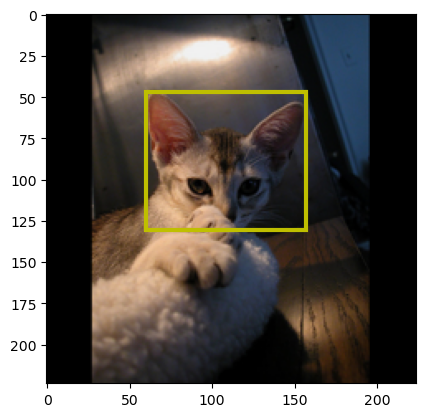

In [11]:
sample_name = 'Abyssinian_10'
image, bounding_box = setting_sample_from_name(data_images, data_xmlAnnotations, sample_name, TARGET_SIZE)
plot_with_box(image, bounding_box)

### Data Loader

In [12]:
sample_num = 32
data_pros = []
with open(data_ClassList) as csv_list_file:
    csv_reader = csv.reader(csv_list_file, delimiter=' ')
    cnt = 0
    while cnt < sample_num:
        row = next(csv_reader)
        if row[0].startswith('#'): continue
        # Unpack for readability
        sample_name, class_id, species, breed_id = row
        # Not every image has a bounding box, some files are missing.So, lets ignore those by the following lines
        try:
            image, bounding_box = setting_sample_from_name(data_images, data_xmlAnnotations, sample_name, TARGET_SIZE)
        except FileNotFoundError:
            # This actually happens quite a lot, as you can see in the output.
            # we end up with 7349 samples.
            print(f'cannot find annotations for {sample_name}: so skipped it')
            continue
        # cat = 0 and dog = 1.
        data_tuple = Processed_Data(image, int(species) - 1, bounding_box)
        data_pros.append(data_tuple)
        print(f'Processed {len(data_pros)} samples')
        cnt += 1

Processed 1 samples
Processed 2 samples
Processed 3 samples
Processed 4 samples
cannot find annotations for Abyssinian_104: so skipped it
Processed 5 samples
Processed 6 samples
Processed 7 samples
Processed 8 samples
Processed 9 samples
Processed 10 samples
Processed 11 samples
Processed 12 samples
Processed 13 samples
Processed 14 samples
Processed 15 samples
Processed 16 samples
Processed 17 samples
Processed 18 samples
Processed 19 samples
Processed 20 samples
Processed 21 samples
Processed 22 samples
Processed 23 samples
Processed 24 samples
Processed 25 samples
Processed 26 samples
Processed 27 samples
Processed 28 samples
Processed 29 samples
Processed 30 samples
Processed 31 samples
Processed 32 samples


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/1109677315.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.tight_layout(), fig.show()


(None, None)

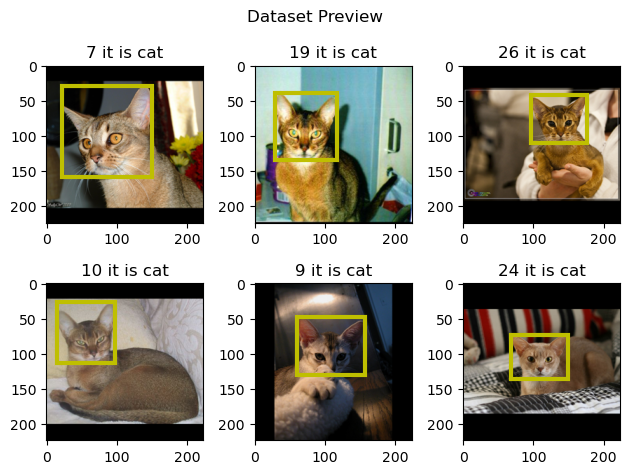

In [13]:
# for checking lets print 6 of them
rand_num = 6

cnt = 0
rand_idc = []
ncols = 3
nrows = (rand_num // ncols) + 1 if rand_num % ncols else rand_num // ncols
fig, axes = plt.subplots(nrows, ncols)
axes = axes.reshape(ncols * nrows)

while cnt < rand_num:
    i = np.random.randint(len(data_pros))
    if i in rand_idc: continue
    rand_idc.append(i)
    image, species, bounding_box = data_pros[i]
    if species == 0:
        title = f"{i} it is cat"
    elif species == 1:
        title = f"{i} it is dog"
    else:
        print("ERROR FOUND: This is of invalid species type")
        title = f"{i} invalid species"
    plot_with_box(image, bounding_box, ax=axes[cnt], title=title)
    cnt += 1

fig.suptitle("Dataset Preview")
fig.tight_layout(), fig.show()

## MobileNet

### Splitting Dataset

In [18]:
dataset = split_dataset(data_pros, mobile_preproc)
print("training dataset size: ", len(dataset.train.x))
print("validation dataset size: ", len(dataset.validation.x))
print("test dataset size: ", len(dataset.test.x))

training dataset size:  22
validation dataset size:  5
test dataset size:  5


### Model Definition

In [19]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
chopped_mobilenet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])
classification_output = GlobalAveragePooling2D()(chopped_mobilenet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)
localization_output = Flatten()(chopped_mobilenet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)
mobile_model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
mobile_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

1/1 [==============================] - 0s 42ms/step
intersection of union = 0.5489813556335648
1/1 [==============================] - 0s 37ms/step
intersection of union = 0.0
1/1 [==============================] - 0s 27ms/step
intersection of union = 0.027951151692315632


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


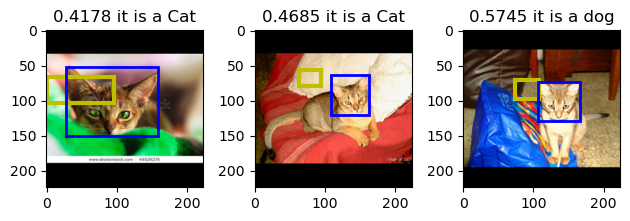

In [44]:
eval(3, dataset.train, mobile_model, data_pros)

### Training

In [20]:
mobile_history = train(mobile_model, dataset, 10)

Epoch 1/10
1/1 [==============================] - 4s 4s/step - loss: 12159.5117 - dense_loss: 0.7882 - dense_1_loss: 11528.9756 - dense_accuracy: 0.5909 - dense_1_accuracy: 0.0909 - val_loss: 5587.5703 - val_dense_loss: 0.6719 - val_dense_1_loss: 5050.0288 - val_dense_accuracy: 0.6000 - val_dense_1_accuracy: 0.2000
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 4710.3594 - dense_loss: 0.7407 - dense_1_loss: 4117.8149 - dense_accuracy: 0.4545 - dense_1_accuracy: 0.2273 - val_loss: 2114.1763 - val_dense_loss: 0.4897 - val_dense_1_loss: 1722.3785 - val_dense_accuracy: 1.0000 - val_dense_1_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 2770.7488 - dense_loss: 0.6904 - dense_1_loss: 2218.4111 - dense_accuracy: 0.5909 - dense_1_accuracy: 0.5000 - val_loss: 1211.6947 - val_dense_loss: 0.4980 - val_dense_1_loss: 813.2833 - val_dense_accuracy: 0.8000 - val_dense_1_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 2s 2

/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/2043872626.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.tight_layout(), fig.show()


(None, None)

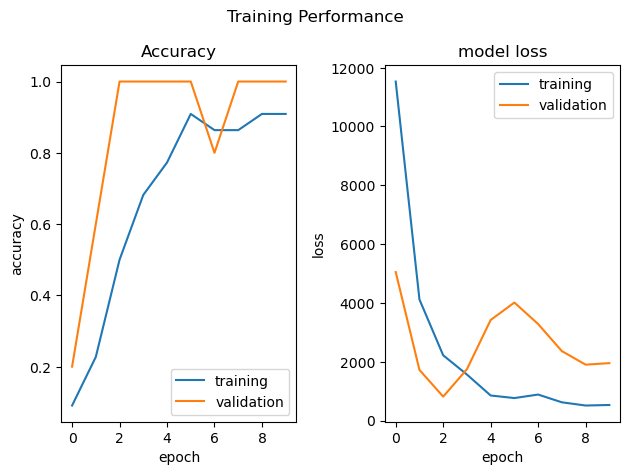

In [21]:
fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.plot(mobile_history.history['dense_1_accuracy'])
ax.plot(mobile_history.history['val_dense_1_accuracy'])
ax.set_title("Accuracy")
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['training', 'validation'], loc='best')

ax = axes[1]
ax.plot(mobile_history.history['dense_1_loss'])
ax.plot(mobile_history.history['val_dense_1_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['training', 'validation'], loc='best')

fig.suptitle("Training Performance")
fig.tight_layout(), fig.show()

1/1 [==============================] - 0s 40ms/step
intersection of union = 0.37435011560823706
1/1 [==============================] - 0s 25ms/step
intersection of union = 0.5489813556335648
1/1 [==============================] - 0s 25ms/step
intersection of union = 0.027951151692315632


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


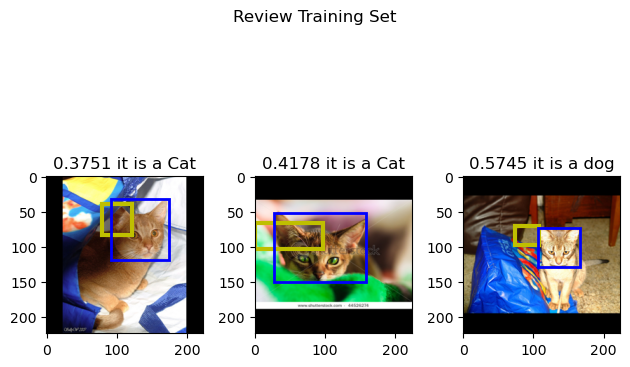

In [32]:
eval(3, dataset.train, mobile_model, data_pros, "Review Training Set")

1/1 [==============================] - 0s 34ms/step
intersection of union = 0.0
1/1 [==============================] - 0s 30ms/step
intersection of union = 0.010720812844707774
1/1 [==============================] - 0s 25ms/step
intersection of union = 0.0


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


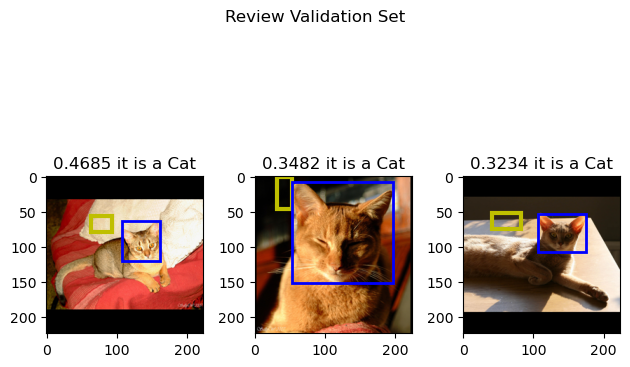

In [34]:
eval(3, dataset.validation, mobile_model, data_pros, "Review Validation Set")

### Evaluation

1/1 [==============================] - 0s 43ms/step
intersection of union = 0.1919152954535583
1/1 [==============================] - 0s 29ms/step
intersection of union = 0.15690827625414833
1/1 [==============================] - 0s 30ms/step
intersection of union = 0.2298055775242421


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


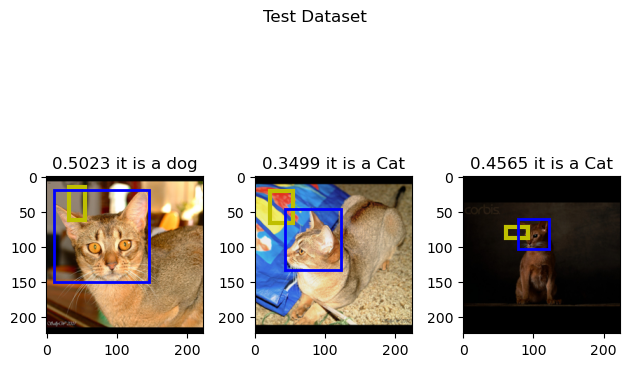

In [35]:
eval(3, dataset.test, mobile_model, data_pros, "Test Dataset")

## ResNet

### Splitting Dataset

In [37]:
dataset = split_dataset(data_pros, res_preproc)
print("training dataset size: ", len(dataset.train.x))
print("validation dataset size: ", len(dataset.validation.x))
print("test dataset size: ", len(dataset.test.x))

training dataset size:  15
validation dataset size:  7
test dataset size:  10


### Model Definition

In [38]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
chopped_resnet = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output])
classification_output = GlobalAveragePooling2D()(chopped_resnet.output)
classification_output = Dense(units=1, activation='sigmoid')(classification_output)
localization_output = Flatten()(chopped_resnet.output)
localization_output = Dense(units=4, activation='relu')(localization_output)
res_model = Model(inputs=[chopped_resnet.input], outputs=[classification_output, localization_output])
res_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

### Training

In [39]:
res_history = train(res_model, dataset, 10)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 12035.9443 - dense_2_loss: 0.8806 - dense_3_loss: 11331.4854 - dense_2_accuracy: 0.0000e+00 - dense_3_accuracy: 0.2000 - val_loss: 3127.5793 - val_dense_2_loss: 0.9478 - val_dense_3_loss: 2369.3140 - val_dense_2_accuracy: 0.1429 - val_dense_3_accuracy: 0.4286
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 2954.0852 - dense_2_loss: 0.7009 - dense_3_loss: 2393.3616 - dense_2_accuracy: 0.5333 - dense_3_accuracy: 0.4667 - val_loss: 2993.4927 - val_dense_2_loss: 0.6864 - val_dense_3_loss: 2444.3411 - val_dense_2_accuracy: 0.5714 - val_dense_3_accuracy: 0.4286
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 3481.6614 - dense_2_loss: 0.5545 - dense_3_loss: 3038.0522 - dense_2_accuracy: 0.8000 - dense_3_accuracy: 0.6667 - val_loss: 2459.8318 - val_dense_2_loss: 0.7048 - val_dense_3_loss: 1895.9939 - val_dense_2_accuracy: 0.5714 - val_dense_3_accuracy: 0.4286
Epoch 4/10
1/1 [=========

/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/3232216350.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.tight_layout(), fig.show()


(None, None)

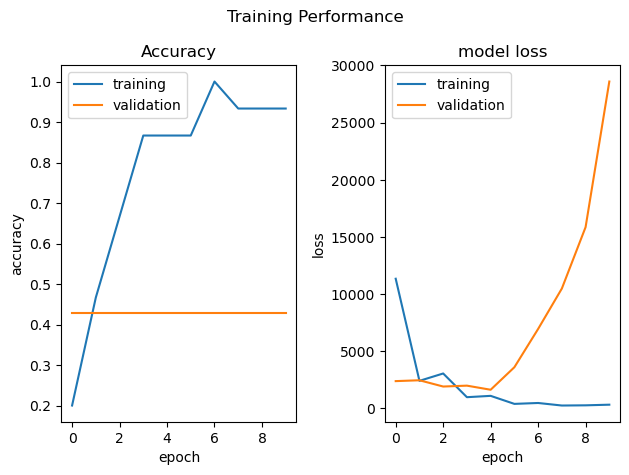

In [40]:
fig, axes = plt.subplots(1,2)

ax = axes[0]
ax.plot(res_history.history['dense_3_accuracy'])
ax.plot(res_history.history['val_dense_3_accuracy'])
ax.set_title("Accuracy")
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['training', 'validation'], loc='best')

ax = axes[1]
ax.plot(res_history.history['dense_3_loss'])
ax.plot(res_history.history['val_dense_3_loss'])
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['training', 'validation'], loc='best')

fig.suptitle("Training Performance")
fig.tight_layout(), fig.show()

1/1 [==============================] - 1s 575ms/step
intersection of union = 0.21773810894767057
1/1 [==============================] - 0s 48ms/step
intersection of union = 0.06255330193212642
1/1 [==============================] - 0s 46ms/step
intersection of union = 0.023129268751314082


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


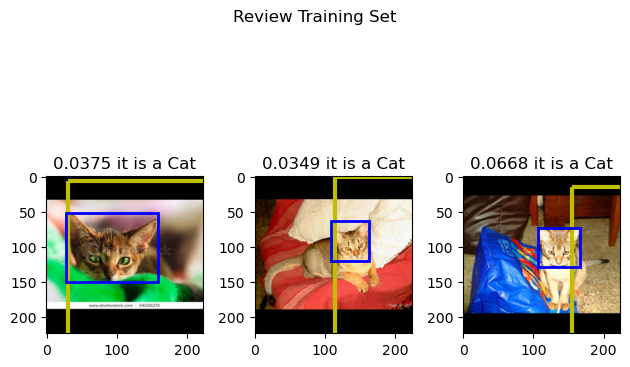

In [41]:
eval(3, dataset.train, res_model, data_pros, "Review Training Set")

1/1 [==============================] - 0s 63ms/step
intersection of union = 0.14350515618017493
1/1 [==============================] - 0s 49ms/step
intersection of union = 0.0
1/1 [==============================] - 0s 50ms/step
intersection of union = 0.09928374044600811


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


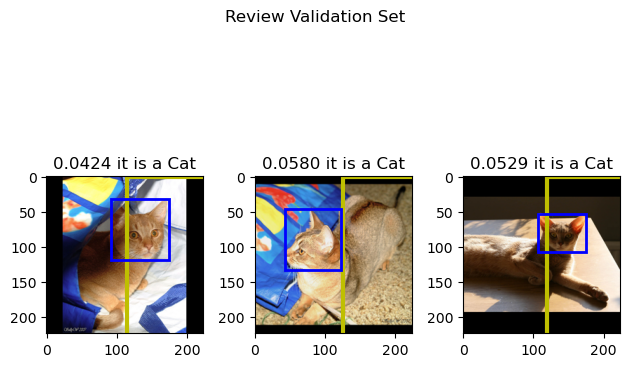

In [42]:
eval(3, dataset.validation, res_model, data_pros, "Review Validation Set")

### Evaluation

1/1 [==============================] - 0s 45ms/step
intersection of union = 0.07887360529328666
1/1 [==============================] - 0s 45ms/step
intersection of union = 0.18017513929443515
1/1 [==============================] - 0s 45ms/step
intersection of union = 0.09653536139856445


/var/folders/xr/fqhbtp7x1fgb6h0skt7fjtfh0000gn/T/ipykernel_14693/201005769.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.suptitle(suptitle), fig.tight_layout(), fig.show()


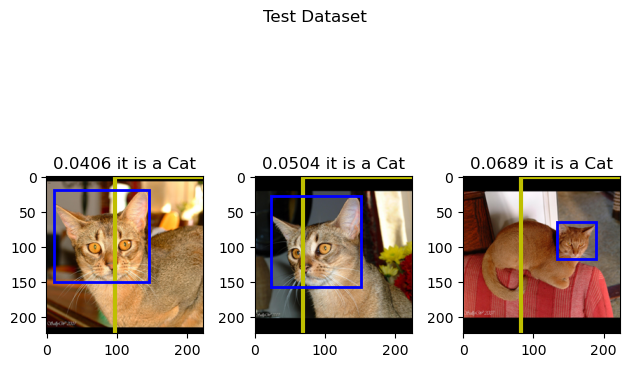

In [43]:
eval(3, dataset.test, res_model, data_pros, "Test Dataset") 